In [1]:
!mkdir train
!mkdir train/NORMAL
!mkdir train/PNEUMONIA
!mkdir val
!mkdir val/NORMAL
!mkdir val/PNEUMONIA
!mkdir test
!mkdir test/NORMAL
!mkdir test/PNEUMONIA

In [2]:
import os
import shutil
import pickle
with open('/kaggle/input/photos/photos.pickle', 'rb') as f:
    photos=pickle.load(f)
print(photos['train_normal'][0])

4056cac3-6aef-4e85-b40d-166f86811ca4.dcm


In [3]:
source_dir='/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
for x in photos['train_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/train/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['train_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/train/PNEUMONIA/', x)
  shutil.copy(src, dst)
for x in photos['val_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/val/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['val_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/val/PNEUMONIA/', x)
  shutil.copy(src, dst)
for x in photos['test_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/test/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['test_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/test/PNEUMONIA/', x)
  shutil.copy(src, dst)


In [4]:

normal_images = os.listdir('train/NORMAL')
pneumonia_images = os.listdir('train/PNEUMONIA')
print('Тренировочная выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))
print()

normal_images = os.listdir('val/NORMAL')
pneumonia_images = os.listdir('val/PNEUMONIA')

print('Валидационная выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))
print()


normal_images = os.listdir('test/NORMAL')
pneumonia_images = os.listdir('test/PNEUMONIA')

print('Тестовая выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))


Тренировочная выборка:
Без пневмонии  16024
C пневмонией  4660

Валидационная выборка:
Без пневмонии  3099
C пневмонией  901

Тестовая выборка:
Без пневмонии  1549
C пневмонией  451


In [5]:
from tqdm import tqdm
import pydicom
from PIL import Image

def convert_dicom_to_jpeg(input_folder, output_folder):
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith('.dcm'):
            dicom_file = os.path.join(input_folder, filename)
            dicom_data = pydicom.dcmread(dicom_file)

            image_array = dicom_data.pixel_array
            jpeg_file = os.path.splitext(filename)[0] + '.jpeg'
            jpeg_path = os.path.join(output_folder, jpeg_file)
            image = Image.fromarray(image_array)
            image.save(jpeg_path, "JPEG")
convert_dicom_to_jpeg('/kaggle/working/train/NORMAL', '/kaggle/working/train/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/train/PNEUMONIA', '/kaggle/working/train/PNEUMONIA')
convert_dicom_to_jpeg('/kaggle/working/val/NORMAL', '/kaggle/working/val/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/val/PNEUMONIA', '/kaggle/working/val/PNEUMONIA')
convert_dicom_to_jpeg('/kaggle/working/test/NORMAL', '/kaggle/working/test/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/test/PNEUMONIA', '/kaggle/working/test/PNEUMONIA')

100%|██████████| 451/451 [00:03<00:00, 133.59it/s]


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-08-29 08:58:15.855692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 08:58:15.855827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 08:58:15.995531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.metrics import AUC

In [18]:
from tensorflow.keras.applications import VGG19 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
base_model = VGG19(include_top=False, weights=None, input_shape=(256, 256, 3))

x = base_model.output
#x = GlobalAveragePooling2D()(x)
x=Flatten()(x)
#x = Dense(100, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary() )

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,057,153 (76.51 MB)

 Trainable params: 20,057,153 (76.51 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

'''
base_model = InceptionV3(include_top=False, input_shape=(512, 512, 3))

for layer in base_model.layers[:600]:
    layer.trainable = False
for layer in base_model.layers[600:]:
    layer.trainable = True

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
'''
optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001)

loss=tf.keras.losses.BinaryCrossentropy()
#loss=tf.keras.losses.MeanSquaredError()

model.compile(loss=loss,
              optimizer=optimizer,
              metrics= [AUC()])

train_data_dir = '/kaggle/working/train'
val_data_dir = '/kaggle/working/val'
test_data_dir = '/kaggle/working/test'


train_datagen = ImageDataGenerator()#rescale=1./255)
val_datagen = ImageDataGenerator()#rescale=1./255)
test_datagen = ImageDataGenerator()#rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        #target_size=(1024, 1024),
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

checkpoint_filepath = 'saved_model/big_dataset_model.keras'
#checkpoint_dir = os.path.dirname(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc_3',
    mode='max',
    save_best_only=True)



history=model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[model_checkpoint_callback], verbose=2)


In [21]:
#!mkdir ckpt
model=tf.keras.models.load_model(checkpoint_filepath)

In [22]:
import matplotlib.pyplot as plt
auc_1 = history.history['auc_1']
val_auc_1 = history.history['val_auc_1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(auc_1) + 1)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, auc_1, 'b', label='train roc_auc', color='orange')
plt.plot(epochs, val_auc_1, 'b', label='validation roc_auc')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='train loss', color='orange')
plt.plot(epochs, val_loss, 'b', label='validation loss')
#plt.title('Потери на обучении и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.savefig('curves.png')
plt.show()

NameError: name 'history' is not defined

In [29]:
model.save('VGG19.keras')

In [23]:


val_generator = val_datagen.flow_from_directory(
        '/kaggle/working/val',
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary',
        shuffle=False)
pred=model.predict(val_generator)

Found 4000 images belonging to 2 classes.
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step


In [24]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(val_generator.classes, pred)

0.8464647397982737

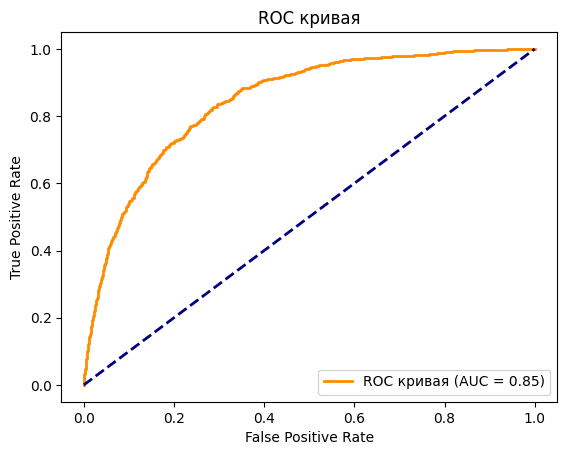

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(val_generator.classes, pred, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()


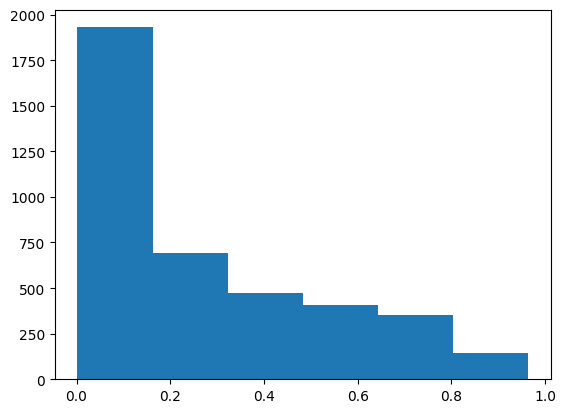

In [27]:
plt.hist(pred, bins=6)
plt.show()

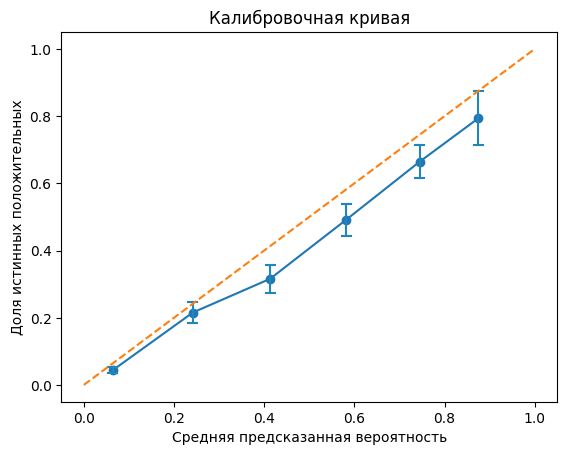

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

preds = np.squeeze(pred)
num_bins=6
prob_true, prob_pred = calibration_curve(val_generator.classes, preds, n_bins=num_bins)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(pred)) :
        if threshold>pred[j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000, solver='lbfgs')
lr.fit(pred.reshape(-1,1), val_generator.classes)
print(lr.coef_)
print(lr.intercept_)

[[5.28693423]]
[-3.06494384]


In [31]:
import pickle


with open('calibration_VGG19.pkl','wb') as f:
    pickle.dump(lr,f)


In [32]:
print(lr.predict_proba(pred)[:, 1])

[0.04985752 0.1095171  0.13940398 ... 0.07401252 0.73341448 0.5112503 ]


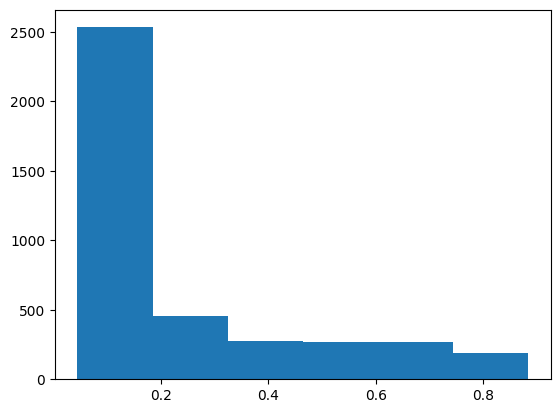

In [33]:
plt.hist(lr.predict_proba(pred)[:, 1], bins=6)
plt.show()

In [34]:
print(sum(lr.predict_proba(pred)[:, 1]>1-1/6))
print(sum(lr.predict_proba(pred)[:, 1]>1-1/5))

36
81


[0.07592367 0.28623188 0.41158537 0.56050955 0.70358306 0.80555556]
[0.07657947 0.24197089 0.41643204 0.58238721 0.74496424 0.85147399]


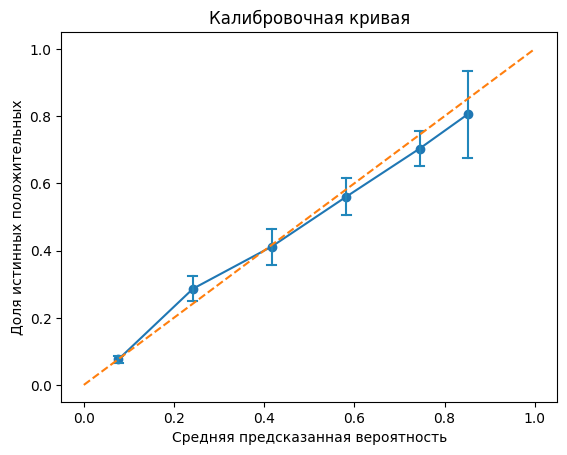

In [35]:
preds = np.squeeze(pred)
num_bins=6
prob_true, prob_pred = calibration_curve(val_generator.classes, lr.predict_proba(pred)[:, 1], n_bins=num_bins)
print(prob_true)
print(prob_pred)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(lr.predict_proba(pred)[:, 1])) :
        if threshold>lr.predict_proba(pred)[:, 1][j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [36]:

test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/test',
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary',
        shuffle=False)
pred=model.predict(test_generator)


Found 2000 images belonging to 2 classes.
  1/100 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step


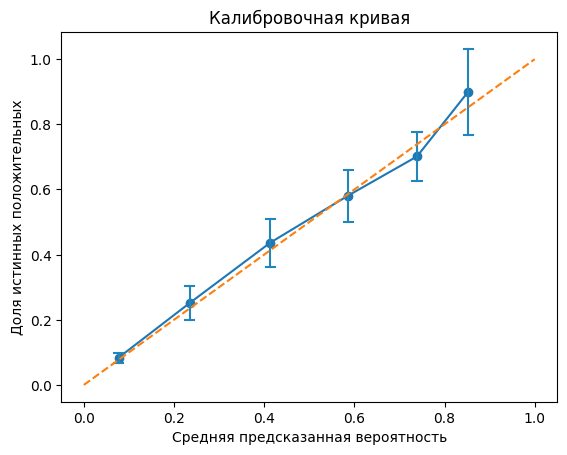

In [39]:

preds = np.squeeze(pred)
num_bins=6
prob_true, prob_pred = calibration_curve(test_generator.classes, lr.predict_proba(pred)[:, 1], n_bins=num_bins)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(lr.predict_proba(pred)[:, 1])) :
        if threshold>lr.predict_proba(pred)[:, 1][j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [40]:
print(sum(lr.predict_proba(pred)[:, 1]>1-1/6))
print(sum(lr.predict_proba(pred)[:, 1]>1-1/5))

20
39


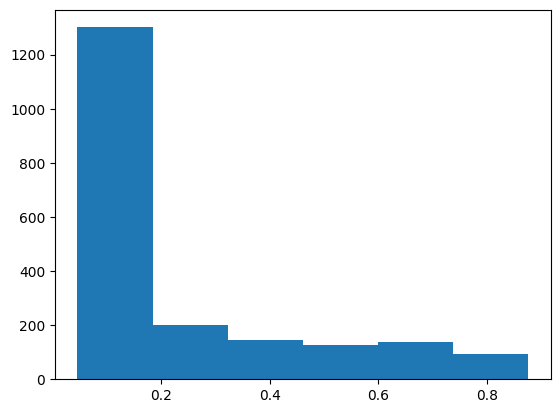

In [42]:
plt.hist(lr.predict_proba(pred)[:, 1], bins=6)
plt.show()

In [143]:
test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/test',
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary',
        shuffle=False)


Found 2000 images belonging to 2 classes.


In [43]:
def predict(photos) :
    predictions=model.predict(photos)
    calibrated_probabilities=lr.predict_proba(predictions)[:, 1]
    return calibrated_probabilities

In [44]:
probas=predict(test_generator)

print(len(probas))

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step
2000


In [45]:
roc_auc_score(test_generator.classes, probas)

0.8350298239762726